In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale
import copy
import seaborn as sns
import heapq
import scipy.stats as stats
from dtw import *
import dtw
from scipy.signal import hilbert, butter, filtfilt
import seaborn as sns
import copy
import scipy.stats as stats
from IPython.display import Image, display
from collections import Counter, OrderedDict
from itertools import chain
#import emd

# Functions

## Moving Window PCC

In [26]:
def moving_window_pcc(covid_data, symptom_data, symptoms, data_type, region, window_size = 4):
    r_window_size = window_size
    pccs = []
    for n, symptom in enumerate(symptoms):
        f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
        covid_normalized = covid_data / covid_data.max()
        symptom_normalized = symptom_data[symptom].interpolate()/symptom_data[symptom].interpolate().max()
        tempdf = pd.DataFrame([*zip(covid_normalized, symptom_normalized)], columns = ['new_cases', symptom])
        #print(tempdf)
        tempdf.rolling(window=4,center=True).median().plot(ax=ax[0])
        ax[0].set(xlabel='Frame',ylabel=data_type)
        # Compute rolling window synchrony
        rolling_r = tempdf.new_cases.rolling(window=r_window_size, center=True).corr(tempdf[symptom])
        #print(tempdf.new_cases.rolling(window=r_window_size, center=True).corr(tempdf[symptom])) #symptom_normalized.rolling(window=r_window_size, center=True).corr(covid_normalized)
        #print(covid_normalized.isnull().values.any(), symptom_normalized.isnull().values.any(), covid_normalized.cov(symptom_normalized))
        rolling_r.plot(ax=ax[1])
        pccs.append(rolling_r)
        ax[1].set(xlabel='Frame')
        plt.suptitle(f"{data_type} and rolling window Pearson's correlation")
        plt.savefig(f"new_plots/{data_type}_{region}_{symptom}_moving_windows_pcc.png")
        #plt.show()
        plt.close()
    return pd.DataFrame(np.array(pccs).T, columns = list(symptoms)).fillna(0).describe().loc[['mean','25%','50%','75%']].sort_values(by=['mean'], axis=1, ascending=False).iloc[:, : 15]

### Read trends data

In [27]:
df_2022 = pd.read_csv('2022_country_daily_2022_US_daily_symptoms_dataset.csv')
df_2021 = pd.read_csv('2021_country_daily_2021_US_daily_symptoms_dataset.csv')
df_2020 = pd.read_csv('2020_country_daily_2020_US_daily_symptoms_dataset.csv')
df = pd.concat([df_2020, df_2021, df_2022], ignore_index=True)
df.sub_region_1.replace(np.nan, "national", inplace=True)
df

,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,place_id,date,symptom:Abdominal obesity,symptom:Abdominal pain,...,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US,United States,national,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-01-01,2.42,4.71,...,1.23,0.23,0.32,3.13,0.34,2.65,0.36,0.17,0.42,0.36
1,US,United States,national,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-01-02,2.40,4.66,...,1.33,0.25,0.37,3.36,0.33,2.60,0.39,0.16,0.51,0.43
2,US,United States,national,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-01-03,2.13,4.54,...,1.29,0.24,0.36,3.17,0.32,2.46,0.38,0.16,0.49,0.39
3,US,United States,national,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-01-04,2.30,4.60,...,1.24,0.24,0.34,3.15,0.31,2.71,0.38,0.17,0.50,0.37
4,US,United States,national,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-01-05,2.53,4.59,...,1.25,0.24,0.34,3.38,0.31,2.81,0.38,0.17,0.49,0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53035,US,United States,Wyoming,US-WY,NaN,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-12,1.56,4.32,...,0.96,NaN,0.69,2.63,NaN,1.51,NaN,NaN,0.49,0.52
53036,US,United States,Wyoming,US-WY,NaN,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-13,0.99,4.03,...,1.17,NaN,0.89,2.79,NaN,1.77,NaN,NaN,NaN,0.67
53037,US,United States,Wyoming,US-WY,NaN,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-14,1.14,4.12,...,1.16,NaN,NaN,2.21,NaN,1.65,NaN,NaN,NaN,NaN
53038,US,United States,Wyoming,US-WY,NaN,NaN,ChIJaS7hSDTiXocRLzh90nkisCY,2022-10-15,1.20,4.06,...,1.55,NaN,NaN,2.46,NaN,1.83,NaN,NaN,NaN,NaN


### Read covid data

In [28]:
covid_data = pd.read_csv('Weekly_United_States_COVID-19_Cases_and_Deaths_by_State.csv')
for n, week in copy.copy(covid_data.groupby('date_updated')):
    week = week.reset_index(drop=True)
    tempdf = pd.DataFrame([[week.date_updated.loc[0], 'national', week.start_date.loc[0], week.end_date.loc[0], week.tot_cases.sum(), week.new_cases.sum(), week.tot_deaths.sum(), week.new_deaths.sum()]], columns = covid_data.columns)
    covid_data = pd.concat([covid_data, tempdf], ignore_index= True)

In [31]:
symptoms = ["symptom:Abdominal obesity","symptom:Abdominal pain","symptom:Acne","symptom:Actinic keratosis","symptom:Acute bronchitis","symptom:Adrenal crisis","symptom:Ageusia","symptom:Alcoholism","symptom:Allergic conjunctivitis","symptom:Allergy","symptom:Amblyopia","symptom:Amenorrhea","symptom:Amnesia","symptom:Anal fissure","symptom:Anaphylaxis","symptom:Anemia","symptom:Angina pectoris","symptom:Angioedema","symptom:Angular cheilitis","symptom:Anosmia","symptom:Anxiety","symptom:Aphasia","symptom:Aphonia","symptom:Apnea","symptom:Arthralgia","symptom:Arthritis","symptom:Ascites","symptom:Asperger syndrome","symptom:Asphyxia","symptom:Asthma","symptom:Astigmatism","symptom:Ataxia","symptom:Atheroma","symptom:Attention deficit hyperactivity disorder","symptom:Auditory hallucination","symptom:Autoimmune disease","symptom:Avoidant personality disorder","symptom:Back pain","symptom:Bacterial vaginosis","symptom:Balance disorder","symptom:Beau's lines","symptom:Bell's palsy","symptom:Biliary colic","symptom:Binge eating","symptom:Bleeding","symptom:Bleeding on probing","symptom:Blepharospasm","symptom:Bloating","symptom:Blood in stool","symptom:Blurred vision","symptom:Blushing","symptom:Boil","symptom:Bone fracture","symptom:Bone tumor","symptom:Bowel obstruction","symptom:Bradycardia","symptom:Braxton Hicks contractions","symptom:Breakthrough bleeding","symptom:Breast pain","symptom:Bronchitis","symptom:Bruise","symptom:Bruxism","symptom:Bunion","symptom:Burn","symptom:Burning Chest Pain","symptom:Burning mouth syndrome","symptom:Candidiasis","symptom:Canker sore","symptom:Cardiac arrest","symptom:Carpal tunnel syndrome","symptom:Cataplexy","symptom:Cataract","symptom:Chancre","symptom:Cheilitis","symptom:Chest pain","symptom:Chills","symptom:Chorea","symptom:Chronic pain","symptom:Cirrhosis","symptom:Cleft lip and cleft palate","symptom:Clouding of consciousness","symptom:Cluster headache","symptom:Colitis","symptom:Coma","symptom:Common cold","symptom:Compulsive behavior","symptom:Compulsive hoarding","symptom:Confusion","symptom:Congenital heart defect","symptom:Conjunctivitis","symptom:Constipation","symptom:Convulsion","symptom:Cough","symptom:Crackles","symptom:Cramp","symptom:Crepitus","symptom:Croup","symptom:Cyanosis","symptom:Dandruff","symptom:Delayed onset muscle soreness","symptom:Dementia","symptom:Dentin hypersensitivity","symptom:Depersonalization","symptom:Depression","symptom:Dermatitis","symptom:Desquamation","symptom:Developmental disability","symptom:Diabetes","symptom:Diabetic ketoacidosis","symptom:Diarrhea","symptom:Dizziness","symptom:Dry eye syndrome","symptom:Dysautonomia","symptom:Dysgeusia","symptom:Dysmenorrhea","symptom:Dyspareunia","symptom:Dysphagia","symptom:Dysphoria","symptom:Dystonia","symptom:Dysuria","symptom:Ear pain","symptom:Eczema","symptom:Edema","symptom:Encephalitis","symptom:Encephalopathy","symptom:Epidermoid cyst","symptom:Epilepsy","symptom:Epiphora","symptom:Erectile dysfunction","symptom:Erythema","symptom:Erythema chronicum migrans","symptom:Esophagitis","symptom:Excessive daytime sleepiness","symptom:Eye pain","symptom:Eye strain","symptom:Facial nerve paralysis","symptom:Facial swelling","symptom:Fasciculation","symptom:Fatigue","symptom:Fatty liver disease","symptom:Fecal incontinence","symptom:Fever","symptom:Fibrillation","symptom:Fibrocystic breast changes","symptom:Fibromyalgia","symptom:Flatulence","symptom:Floater","symptom:Focal seizure","symptom:Folate deficiency","symptom:Food craving","symptom:Food intolerance","symptom:Frequent urination","symptom:Gastroesophageal reflux disease","symptom:Gastroparesis","symptom:Generalized anxiety disorder","symptom:Generalized tonic–clonic seizure","symptom:Genital wart","symptom:Gingival recession","symptom:Gingivitis","symptom:Globus pharyngis","symptom:Goitre","symptom:Gout","symptom:Grandiosity","symptom:Granuloma","symptom:Guilt","symptom:Hair loss","symptom:Halitosis","symptom:Hay fever","symptom:Headache","symptom:Heart arrhythmia","symptom:Heart murmur","symptom:Heartburn","symptom:Hematochezia","symptom:Hematoma","symptom:Hematuria","symptom:Hemolysis","symptom:Hemoptysis","symptom:Hemorrhoids","symptom:Hepatic encephalopathy","symptom:Hepatitis","symptom:Hepatotoxicity","symptom:Hiccup","symptom:Hip pain","symptom:Hives","symptom:Hot flash","symptom:Hydrocephalus","symptom:Hypercalcaemia","symptom:Hypercapnia","symptom:Hypercholesterolemia","symptom:Hyperemesis gravidarum","symptom:Hyperglycemia","symptom:Hyperkalemia","symptom:Hyperlipidemia","symptom:Hypermobility","symptom:Hyperpigmentation","symptom:Hypersomnia","symptom:Hypertension","symptom:Hyperthermia","symptom:Hyperthyroidism","symptom:Hypertriglyceridemia","symptom:Hypertrophy","symptom:Hyperventilation","symptom:Hypocalcaemia","symptom:Hypochondriasis","symptom:Hypoglycemia","symptom:Hypogonadism","symptom:Hypokalemia","symptom:Hypomania","symptom:Hyponatremia","symptom:Hypotension","symptom:Hypothyroidism","symptom:Hypoxemia","symptom:Hypoxia","symptom:Impetigo","symptom:Implantation bleeding","symptom:Impulsivity","symptom:Indigestion","symptom:Infection","symptom:Inflammation","symptom:Inflammatory bowel disease","symptom:Ingrown hair","symptom:Insomnia","symptom:Insulin resistance","symptom:Intermenstrual bleeding","symptom:Intracranial pressure","symptom:Iron deficiency","symptom:Irregular menstruation","symptom:Itch","symptom:Jaundice","symptom:Kidney failure","symptom:Kidney stone","symptom:Knee Pain","symptom:Kyphosis","symptom:Lactose intolerance","symptom:Laryngitis","symptom:Leg cramps","symptom:Lesion","symptom:Leukorrhea","symptom:Lightheadedness","symptom:Low back pain","symptom:Low-grade fever","symptom:Lymphedema","symptom:Major depressive disorder","symptom:Malabsorption","symptom:Male infertility","symptom:Manic Disorder","symptom:Melasma","symptom:Melena","symptom:Meningitis","symptom:Menorrhagia","symptom:Middle back pain","symptom:Migraine","symptom:Milium","symptom:Mitral insufficiency","symptom:Mood disorder","symptom:Mood swing","symptom:Morning sickness","symptom:Motion sickness","symptom:Mouth ulcer","symptom:Muscle atrophy","symptom:Muscle weakness","symptom:Myalgia","symptom:Mydriasis","symptom:Myocardial infarction","symptom:Myoclonus","symptom:Nasal congestion","symptom:Nasal polyp","symptom:Nausea","symptom:Neck mass","symptom:Neck pain","symptom:Neonatal jaundice","symptom:Nerve injury","symptom:Neuralgia","symptom:Neutropenia","symptom:Night sweats","symptom:Night terror","symptom:Nocturnal enuresis","symptom:Nodule","symptom:Nosebleed","symptom:Nystagmus","symptom:Obesity","symptom:Onychorrhexis","symptom:Oral candidiasis","symptom:Orthostatic hypotension","symptom:Osteopenia","symptom:Osteophyte","symptom:Osteoporosis","symptom:Otitis","symptom:Otitis externa","symptom:Otitis media","symptom:Pain","symptom:Palpitations","symptom:Panic attack","symptom:Papule","symptom:Paranoia","symptom:Paresthesia","symptom:Pelvic inflammatory disease","symptom:Pericarditis","symptom:Periodontal disease","symptom:Periorbital puffiness","symptom:Peripheral neuropathy","symptom:Perspiration","symptom:Petechia","symptom:Phlegm","symptom:Photodermatitis","symptom:Photophobia","symptom:Photopsia","symptom:Pleural effusion","symptom:Pleurisy","symptom:Pneumonia","symptom:Podalgia","symptom:Polycythemia","symptom:Polydipsia","symptom:Polyneuropathy","symptom:Polyuria","symptom:Poor posture","symptom:Post-nasal drip","symptom:Postural orthostatic tachycardia syndrome","symptom:Prediabetes","symptom:Proteinuria","symptom:Pruritus ani","symptom:Psychosis","symptom:Ptosis","symptom:Pulmonary edema","symptom:Pulmonary hypertension","symptom:Purpura","symptom:Pus","symptom:Pyelonephritis","symptom:Radiculopathy","symptom:Rectal pain","symptom:Rectal prolapse","symptom:Red eye","symptom:Renal colic","symptom:Restless legs syndrome","symptom:Rheum","symptom:Rhinitis","symptom:Rhinorrhea","symptom:Rosacea","symptom:Round ligament pain","symptom:Rumination","symptom:Scar","symptom:Sciatica","symptom:Scoliosis","symptom:Seborrheic dermatitis","symptom:Self-harm","symptom:Sensitivity to sound","symptom:Sexual dysfunction","symptom:Shallow breathing","symptom:Sharp pain","symptom:Shivering","symptom:Shortness of breath","symptom:Shyness","symptom:Sinusitis","symptom:Skin condition","symptom:Skin rash","symptom:Skin tag","symptom:Skin ulcer","symptom:Sleep apnea","symptom:Sleep deprivation","symptom:Sleep disorder","symptom:Snoring","symptom:Sore throat","symptom:Spasticity","symptom:Splenomegaly","symptom:Sputum","symptom:Stomach rumble","symptom:Strabismus","symptom:Stretch marks","symptom:Stridor","symptom:Stroke","symptom:Stuttering","symptom:Subdural hematoma","symptom:Suicidal ideation","symptom:Swelling","symptom:Swollen feet","symptom:Swollen lymph nodes","symptom:Syncope","symptom:Tachycardia","symptom:Tachypnea","symptom:Telangiectasia","symptom:Tenderness","symptom:Testicular pain","symptom:Throat irritation","symptom:Thrombocytopenia","symptom:Thyroid nodule","symptom:Tic","symptom:Tinnitus","symptom:Tonsillitis","symptom:Toothache","symptom:Tremor","symptom:Trichoptilosis","symptom:Tumor","symptom:Type 2 diabetes","symptom:Unconsciousness","symptom:Underweight","symptom:Upper respiratory tract infection","symptom:Urethritis","symptom:Urinary incontinence","symptom:Urinary tract infection","symptom:Urinary urgency","symptom:Uterine contraction","symptom:Vaginal bleeding","symptom:Vaginal discharge","symptom:Vaginitis","symptom:Varicose veins","symptom:Vasculitis","symptom:Ventricular fibrillation","symptom:Ventricular tachycardia","symptom:Vertigo","symptom:Viral pneumonia","symptom:Visual acuity","symptom:Vomiting","symptom:Wart","symptom:Water retention","symptom:Weakness","symptom:Weight gain","symptom:Wheeze","symptom:Xeroderma","symptom:Xerostomia","symptom:Yawn","symptom:hyperhidrosis","symptom:pancreatitis"]
meta_column = ["country_region_code","country_region","sub_region_1","sub_region_1_code","sub_region_2","sub_region_2_code","place_id","date"]
state_to_symbol = {'national': 'national', 'California': 'CA', 'New York': 'NY', 'Georgia': 'GA', 'Texas': 'TX', 'Alaska': 'AK', "Mississippi": 'MS', 'Alabama': 'AL', 'South Carolina': 'SC'}

### Run for window PCC

In [6]:

region = 'national'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_national = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_national

,symptom:Ageusia,symptom:Hypoxemia,symptom:Low-grade fever,symptom:Dysgeusia,symptom:Fever,symptom:Anosmia,symptom:Chills,symptom:Pneumonia,symptom:Shallow breathing,symptom:Eye pain,symptom:Shortness of breath,symptom:Headache,symptom:Shivering,symptom:Migraine,symptom:Hyperthermia
mean,0.659556,0.564667,0.558120,0.498466,0.477939,0.465239,0.424078,0.419668,0.383507,0.382942,0.360365,0.354756,0.347209,0.336660,0.328035
25%,0.467216,0.224008,0.385716,0.198660,0.022231,0.000000,0.000000,-0.013236,-0.036319,0.000000,-0.029391,-0.015712,-0.065019,-0.072874,-0.237812
50%,0.920991,0.856297,0.865126,0.738526,0.823813,0.721636,0.710976,0.768859,0.550516,0.615887,0.519972,0.597497,0.549565,0.561879,0.572820
75%,0.986022,0.973464,0.961810,0.939885,0.964038,0.979161,0.919971,0.955298,0.862289,0.929268,0.931422,0.902468,0.857282,0.882091,0.905029


In [7]:
region = 'California'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_cali = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_cali

,symptom:Ageusia,symptom:Hypoxemia,symptom:Dysgeusia,symptom:Low-grade fever,symptom:Fever,symptom:Anosmia,symptom:Arthralgia,symptom:Shortness of breath,symptom:Pneumonia,symptom:Clouding of consciousness,symptom:Migraine,symptom:Night sweats,symptom:Weakness,symptom:Eye pain,symptom:Bradycardia
mean,0.578138,0.519596,0.431328,0.421319,0.393365,0.390934,0.345729,0.300381,0.289309,0.279755,0.274446,0.266300,0.258057,0.254598,0.253977
25%,0.372484,0.281315,0.029830,0.016756,-0.020599,-0.019605,-0.113911,-0.084538,-0.321782,-0.137814,-0.294848,-0.222479,-0.203724,-0.314803,-0.197945
50%,0.819316,0.817034,0.624533,0.627947,0.618670,0.680540,0.550272,0.429230,0.527639,0.364756,0.476140,0.394914,0.447906,0.417695,0.437986
75%,0.967051,0.968597,0.933534,0.956099,0.924914,0.943560,0.819888,0.889687,0.913331,0.813481,0.877198,0.827333,0.832785,0.800301,0.817895


In [8]:
region = 'Texas'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_texas = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_texas

,symptom:Hypoxemia,symptom:Ageusia,symptom:Fever,symptom:Dysgeusia,symptom:Low-grade fever,symptom:Headache,symptom:Pneumonia,symptom:Shortness of breath,symptom:Shivering,symptom:Anosmia,symptom:Eye pain,symptom:Bradycardia,symptom:Shallow breathing,symptom:Pleurisy,symptom:Migraine
mean,0.498309,0.458312,0.393832,0.365552,0.358983,0.326959,0.309085,0.302579,0.284723,0.280305,0.273126,0.264195,0.262764,0.255033,0.248700
25%,0.000000,0.129437,0.000000,0.000000,-0.072734,-0.163772,-0.177836,-0.128494,-0.220731,-0.232651,-0.251631,-0.264130,-0.187121,-0.240879,-0.165800
50%,0.760669,0.681874,0.594372,0.541982,0.576541,0.591570,0.578063,0.490716,0.478911,0.485945,0.428008,0.396472,0.377041,0.452114,0.357999
75%,0.943598,0.948621,0.913113,0.871570,0.914460,0.876313,0.892800,0.864360,0.858971,0.889023,0.832478,0.840927,0.786396,0.782987,0.771758


In [9]:
region = 'New York'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_nyc = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_nyc

,symptom:Ageusia,symptom:Low-grade fever,symptom:Hypoxemia,symptom:Anosmia,symptom:Fever,symptom:Shortness of breath,symptom:Dysgeusia,symptom:Night sweats,symptom:Viral pneumonia,symptom:Pneumonia,symptom:Chills,symptom:Hyperthermia,symptom:Common cold,symptom:Sputum,symptom:Chest pain
mean,0.629802,0.621296,0.596122,0.502379,0.498593,0.430143,0.422586,0.391022,0.359967,0.358202,0.357725,0.337463,0.315354,0.298884,0.298068
25%,0.404191,0.381033,0.337398,0.229816,0.177644,0.052496,0.030582,0.029853,-0.019061,-0.038814,0.000000,-0.107611,-0.122595,-0.138382,-0.045041
50%,0.860530,0.854721,0.800933,0.733820,0.765549,0.659726,0.621083,0.559912,0.539005,0.651603,0.512882,0.555440,0.581099,0.472276,0.423065
75%,0.978098,0.953474,0.956432,0.949140,0.931892,0.914481,0.887441,0.803288,0.825544,0.932286,0.863553,0.866547,0.897381,0.871036,0.848492


In [10]:
region = 'Alaska'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_alaska = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_alaska

,symptom:Fever,symptom:Pneumonia,symptom:Cough,symptom:Common cold,symptom:Sore throat,symptom:Sinusitis,symptom:Polyneuropathy,symptom:Compulsive hoarding,symptom:Pleurisy,symptom:Congenital heart defect,symptom:Migraine,symptom:Headache,symptom:Avoidant personality disorder,symptom:Nasal congestion,symptom:Shortness of breath
mean,0.317122,0.261626,0.260536,0.248292,0.204301,0.200675,0.195295,0.180564,0.176331,0.174415,0.159998,0.155617,0.149511,0.148387,0.145745
25%,-0.066430,-0.183956,-0.381854,-0.296228,-0.172739,-0.282039,-0.555481,-0.639895,-0.537216,-0.546915,-0.359010,-0.292243,-0.469706,-0.460136,-0.312512
50%,0.570583,0.357868,0.523371,0.463624,0.238703,0.273173,0.471172,0.345557,0.368164,0.227270,0.190393,0.222888,0.118300,0.232970,0.242256
75%,0.848996,0.845171,0.854661,0.855717,0.809177,0.764272,0.890632,0.949529,0.880121,0.852456,0.719058,0.739249,0.891325,0.760554,0.609734


In [11]:
region = 'Mississippi'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_misi = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_misi

,symptom:Fever,symptom:Low-grade fever,symptom:Hypoxemia,symptom:Anosmia,symptom:Ageusia,symptom:Headache,symptom:Bradycardia,symptom:Heartburn,symptom:Pneumonia,symptom:Common cold,symptom:Sore throat,symptom:hyperhidrosis,symptom:Dysgeusia,symptom:Hyperthermia,symptom:Myalgia
mean,0.361740,0.335458,0.308847,0.259440,0.245627,0.244453,0.213663,0.213077,0.210531,0.174475,0.173509,0.172465,0.164443,0.162525,0.161547
25%,-0.005743,0.000000,-0.129888,-0.240946,-0.251276,-0.201350,-0.213545,-0.280607,-0.498758,-0.544980,-0.448136,-0.189337,-0.298220,-0.322363,-0.255361
50%,0.626133,0.486546,0.515178,0.402383,0.431871,0.431989,0.302106,0.269910,0.436810,0.266620,0.268383,0.254894,0.216703,0.175756,0.202995
75%,0.916868,0.869560,0.870892,0.861573,0.866008,0.791218,0.716599,0.806449,0.896972,0.868856,0.802401,0.695973,0.676293,0.776067,0.723165


In [12]:
region = 'Georgia'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_geo = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_geo

,symptom:Ageusia,symptom:Hypoxemia,symptom:Anosmia,symptom:Low-grade fever,symptom:Fever,symptom:Headache,symptom:Chills,symptom:Dysgeusia,symptom:Pneumonia,symptom:Migraine,symptom:Shivering,symptom:Hyperthermia,symptom:Eye pain,symptom:Chest pain,symptom:Common cold
mean,0.537305,0.502913,0.464663,0.450851,0.401667,0.390132,0.361848,0.332337,0.332141,0.326696,0.314161,0.313743,0.308793,0.265607,0.256896
25%,0.184816,0.002836,0.029081,0.012167,-0.044450,-0.017776,-0.153528,-0.030523,-0.083703,-0.105031,-0.076871,-0.086591,-0.119200,-0.212218,-0.369343
50%,0.718349,0.815638,0.708534,0.762206,0.700308,0.600307,0.595562,0.439835,0.624291,0.561553,0.455995,0.505655,0.508450,0.365750,0.443428
75%,0.971165,0.974468,0.929297,0.943597,0.949411,0.872782,0.952428,0.859820,0.921332,0.791026,0.855237,0.831871,0.795797,0.819057,0.901833


### Neighboring States

In [32]:
region = 'Georgia'
neighbour = "Alabama"
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_alb_ga = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[neighbour]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_alb_ga

,symptom:Hypoxemia,symptom:Ageusia,symptom:Low-grade fever,symptom:Hyperthermia,symptom:Fever,symptom:Anosmia,symptom:Headache,symptom:Shortness of breath,symptom:Chills,symptom:Dysgeusia,symptom:Common cold,symptom:Eye pain,symptom:Bradycardia,symptom:Weakness,symptom:Shivering
mean,0.407062,0.380903,0.362562,0.342085,0.335972,0.291353,0.290557,0.283786,0.279027,0.267170,0.256067,0.243143,0.241892,0.235200,0.234108
25%,0.000000,0.000000,-0.058686,0.000000,-0.067528,-0.282645,-0.189512,-0.110823,-0.137826,-0.039797,-0.180408,-0.274681,-0.207611,-0.107396,-0.180717
50%,0.679570,0.579691,0.650702,0.568153,0.612204,0.550473,0.456585,0.475239,0.371624,0.324948,0.421278,0.400668,0.314643,0.316926,0.280397
75%,0.931520,0.907324,0.880127,0.887256,0.855796,0.899864,0.856049,0.866753,0.861948,0.822090,0.881494,0.762594,0.850096,0.747578,0.839666


In [33]:
region = 'Georgia'
neighbour = "South Carolina"
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_sc_ga = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[neighbour]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_sc_ga

,symptom:Ageusia,symptom:Hypoxemia,symptom:Anosmia,symptom:Fever,symptom:Eye pain,symptom:Low-grade fever,symptom:Headache,symptom:Shortness of breath,symptom:Pneumonia,symptom:Hyperthermia,symptom:Dysgeusia,symptom:Bradycardia,symptom:Infection,symptom:Hypoxia,symptom:Migraine
mean,0.470454,0.442283,0.400563,0.315085,0.300187,0.297225,0.284346,0.271389,0.266395,0.262733,0.253164,0.249310,0.248243,0.247696,0.230314
25%,0.066241,0.000000,0.000000,-0.238341,-0.105535,-0.229877,-0.173198,-0.204209,-0.395165,-0.290200,-0.143254,-0.267085,-0.330687,-0.268922,-0.259912
50%,0.706010,0.736650,0.610250,0.541685,0.385584,0.602228,0.386010,0.433983,0.540736,0.514438,0.311902,0.393859,0.415648,0.374978,0.310826
75%,0.963926,0.961706,0.931314,0.926784,0.803469,0.927402,0.863111,0.900568,0.920586,0.845754,0.884404,0.872227,0.844740,0.874605,0.772525


#### Common Symptoms in ALL the states

In [13]:
u, count = np.unique(np.concatenate((temp_national.columns, temp_cali.columns, temp_nyc.columns, temp_texas.columns, temp_alaska.columns, temp_misi.columns, temp_geo.columns)), return_counts=True)
count_sort_ind = np.argsort(-count)
u[count_sort_ind[:15]], count[count_sort_ind[:15]]

(array(['symptom:Pneumonia', 'symptom:Fever', 'symptom:Ageusia',
        'symptom:Anosmia', 'symptom:Low-grade fever', 'symptom:Hypoxemia',
        'symptom:Dysgeusia', 'symptom:Shortness of breath',
        'symptom:Migraine', 'symptom:Headache', 'symptom:Eye pain',
        'symptom:Hyperthermia', 'symptom:Common cold', 'symptom:Chills',
        'symptom:Bradycardia'], dtype=object),
 array([7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 4, 4, 4, 3, 3]))

## IMF

In [14]:
import emd

In [15]:
def moving_window_imf_pcc(covid_data, symptom_data, symptoms, data_type, region, window_size = 4):
    r_window_size = window_size
    pccs = []
    for n, symptom in enumerate(symptoms):
        f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
        covid_normalized = covid_data / covid_data.max()
        symptom_normalized = symptom_data[symptom].interpolate()/symptom_data[symptom].interpolate().max()
        imf = emd.sift.sift(symptom_normalized.to_numpy())
        symptom_normalized = imf.T[0]+imf.T[1]
        tempdf = pd.DataFrame([*zip(covid_normalized, symptom_normalized)], columns = ['new_cases', symptom])
        #print(tempdf)
        tempdf.rolling(window=4,center=True).median().plot(ax=ax[0])
        ax[0].set(xlabel='Frame',ylabel=data_type)
        # Compute rolling window synchrony
        rolling_r = tempdf.new_cases.rolling(window=r_window_size, center=True).corr(tempdf[symptom])
        #print(tempdf.new_cases.rolling(window=r_window_size, center=True).corr(tempdf[symptom])) #symptom_normalized.rolling(window=r_window_size, center=True).corr(covid_normalized)
        #print(covid_normalized.isnull().values.any(), symptom_normalized.isnull().values.any(), covid_normalized.cov(symptom_normalized))
        rolling_r.plot(ax=ax[1])
        #print(rolling_r)
        pccs.append(rolling_r)
        ax[1].set(xlabel='Frame')
        plt.suptitle(f"{data_type} and rolling window Pearson's correlation")
        plt.savefig(f"new_plots/{data_type}_{region}_{symptom}_moving_windows_imf_pcc.png")
        #plt.show()
        plt.close()
    #pd.DataFrame(np.array(pccs).T, columns = list(df_symptoms.Symptom)).fillna(0).describe().loc[['mean','25%','50%','75%']]
    return pd.DataFrame(np.array(pccs).T, columns = list(symptoms)).fillna(0).describe().loc[['mean','25%','50%','75%']].sort_values(by=['mean'], axis=1, ascending=False).iloc[:, : 15]

In [16]:

region = 'national'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_national_imf = moving_window_imf_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_national_imf

,symptom:Ageusia,symptom:Hypoxemia,symptom:Low-grade fever,symptom:Chills,symptom:Shortness of breath,symptom:Shallow breathing,symptom:Fever,symptom:Pneumonia,symptom:Hyperthermia,symptom:Dysgeusia,symptom:Anosmia,symptom:Eye pain,symptom:Nasal congestion,symptom:Sinusitis,symptom:Cough
mean,0.463050,0.456899,0.414371,0.383682,0.317638,0.295748,0.281348,0.278603,0.270669,0.267174,0.247827,0.241352,0.229596,0.227420,0.226340
25%,0.023897,0.102726,0.000000,-0.027324,-0.174997,-0.099563,-0.479099,-0.406065,-0.300282,-0.368462,-0.479704,-0.463591,-0.411300,-0.331440,-0.631239
50%,0.837629,0.760209,0.804809,0.608982,0.498082,0.409707,0.579715,0.663125,0.506453,0.581285,0.494384,0.451186,0.423763,0.407033,0.666614
75%,0.979069,0.955496,0.965678,0.899494,0.899841,0.814488,0.942219,0.940976,0.852886,0.874631,0.945337,0.865436,0.849790,0.850394,0.925729


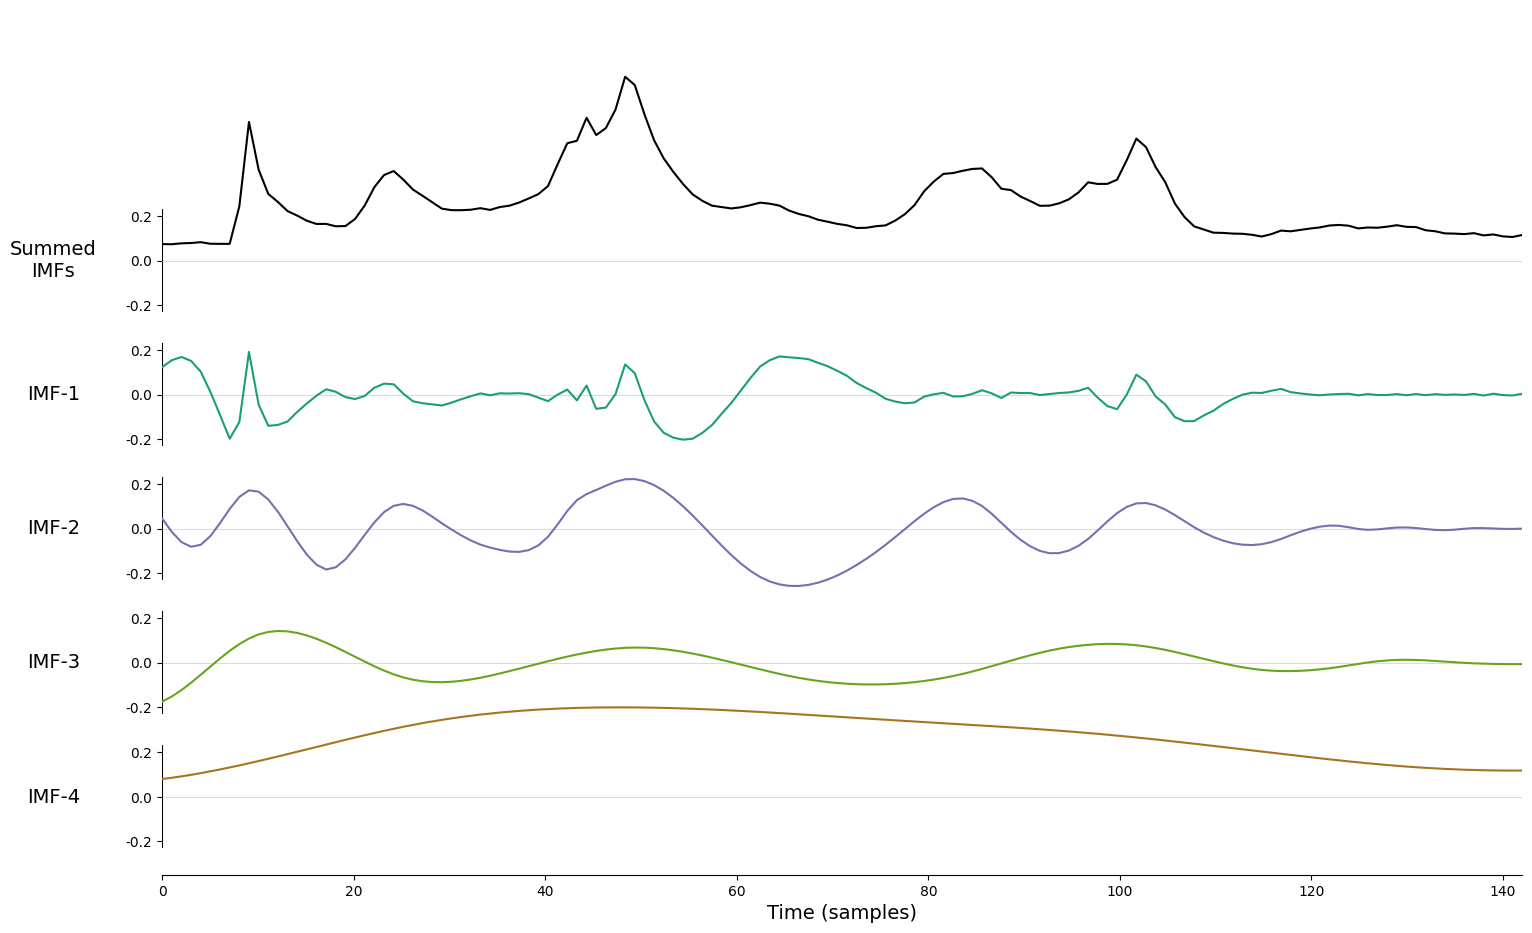

In [17]:
emd.plotting.plot_imfs(emd.sift.sift(tempdf['symptom:Ageusia'].to_numpy()))
plt.savefig('ageusia_imfs.png')

In [19]:
region = 'California'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_cali_imf = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_cali_imf

,symptom:Ageusia,symptom:Hypoxemia,symptom:Dysgeusia,symptom:Low-grade fever,symptom:Fever,symptom:Anosmia,symptom:Arthralgia,symptom:Shortness of breath,symptom:Pneumonia,symptom:Clouding of consciousness,symptom:Migraine,symptom:Night sweats,symptom:Weakness,symptom:Eye pain,symptom:Bradycardia
mean,0.578138,0.519596,0.431328,0.421319,0.393365,0.390934,0.345729,0.300381,0.289309,0.279755,0.274446,0.266300,0.258057,0.254598,0.253977
25%,0.372484,0.281315,0.029830,0.016756,-0.020599,-0.019605,-0.113911,-0.084538,-0.321782,-0.137814,-0.294848,-0.222479,-0.203724,-0.314803,-0.197945
50%,0.819316,0.817034,0.624533,0.627947,0.618670,0.680540,0.550272,0.429230,0.527639,0.364756,0.476140,0.394914,0.447906,0.417695,0.437986
75%,0.967051,0.968597,0.933534,0.956099,0.924914,0.943560,0.819888,0.889687,0.913331,0.813481,0.877198,0.827333,0.832785,0.800301,0.817895


In [20]:
region = 'Texas'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_texas_imf = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_texas_imf

,symptom:Hypoxemia,symptom:Ageusia,symptom:Fever,symptom:Dysgeusia,symptom:Low-grade fever,symptom:Headache,symptom:Pneumonia,symptom:Shortness of breath,symptom:Shivering,symptom:Anosmia,symptom:Eye pain,symptom:Bradycardia,symptom:Shallow breathing,symptom:Pleurisy,symptom:Migraine
mean,0.498309,0.458312,0.393832,0.365552,0.358983,0.326959,0.309085,0.302579,0.284723,0.280305,0.273126,0.264195,0.262764,0.255033,0.248700
25%,0.000000,0.129437,0.000000,0.000000,-0.072734,-0.163772,-0.177836,-0.128494,-0.220731,-0.232651,-0.251631,-0.264130,-0.187121,-0.240879,-0.165800
50%,0.760669,0.681874,0.594372,0.541982,0.576541,0.591570,0.578063,0.490716,0.478911,0.485945,0.428008,0.396472,0.377041,0.452114,0.357999
75%,0.943598,0.948621,0.913113,0.871570,0.914460,0.876313,0.892800,0.864360,0.858971,0.889023,0.832478,0.840927,0.786396,0.782987,0.771758


In [21]:
region = 'New York'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_nyc_imf = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_nyc_imf

,symptom:Ageusia,symptom:Low-grade fever,symptom:Hypoxemia,symptom:Anosmia,symptom:Fever,symptom:Shortness of breath,symptom:Dysgeusia,symptom:Night sweats,symptom:Viral pneumonia,symptom:Pneumonia,symptom:Chills,symptom:Hyperthermia,symptom:Common cold,symptom:Sputum,symptom:Chest pain
mean,0.629802,0.621296,0.596122,0.502379,0.498593,0.430143,0.422586,0.391022,0.359967,0.358202,0.357725,0.337463,0.315354,0.298884,0.298068
25%,0.404191,0.381033,0.337398,0.229816,0.177644,0.052496,0.030582,0.029853,-0.019061,-0.038814,0.000000,-0.107611,-0.122595,-0.138382,-0.045041
50%,0.860530,0.854721,0.800933,0.733820,0.765549,0.659726,0.621083,0.559912,0.539005,0.651603,0.512882,0.555440,0.581099,0.472276,0.423065
75%,0.978098,0.953474,0.956432,0.949140,0.931892,0.914481,0.887441,0.803288,0.825544,0.932286,0.863553,0.866547,0.897381,0.871036,0.848492


In [22]:
region = 'Alaska'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_alaska_imf = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_alaska_imf

,symptom:Fever,symptom:Pneumonia,symptom:Cough,symptom:Common cold,symptom:Sore throat,symptom:Sinusitis,symptom:Polyneuropathy,symptom:Compulsive hoarding,symptom:Pleurisy,symptom:Congenital heart defect,symptom:Migraine,symptom:Headache,symptom:Avoidant personality disorder,symptom:Nasal congestion,symptom:Shortness of breath
mean,0.317122,0.261626,0.260536,0.248292,0.204301,0.200675,0.195295,0.180564,0.176331,0.174415,0.159998,0.155617,0.149511,0.148387,0.145745
25%,-0.066430,-0.183956,-0.381854,-0.296228,-0.172739,-0.282039,-0.555481,-0.639895,-0.537216,-0.546915,-0.359010,-0.292243,-0.469706,-0.460136,-0.312512
50%,0.570583,0.357868,0.523371,0.463624,0.238703,0.273173,0.471172,0.345557,0.368164,0.227270,0.190393,0.222888,0.118300,0.232970,0.242256
75%,0.848996,0.845171,0.854661,0.855717,0.809177,0.764272,0.890632,0.949529,0.880121,0.852456,0.719058,0.739249,0.891325,0.760554,0.609734


In [23]:
region = 'Mississippi'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_misi_imf = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_misi_imf

,symptom:Fever,symptom:Low-grade fever,symptom:Hypoxemia,symptom:Anosmia,symptom:Ageusia,symptom:Headache,symptom:Bradycardia,symptom:Heartburn,symptom:Pneumonia,symptom:Common cold,symptom:Sore throat,symptom:hyperhidrosis,symptom:Dysgeusia,symptom:Hyperthermia,symptom:Myalgia
mean,0.361740,0.335458,0.308847,0.259440,0.245627,0.244453,0.213663,0.213077,0.210531,0.174475,0.173509,0.172465,0.164443,0.162525,0.161547
25%,-0.005743,0.000000,-0.129888,-0.240946,-0.251276,-0.201350,-0.213545,-0.280607,-0.498758,-0.544980,-0.448136,-0.189337,-0.298220,-0.322363,-0.255361
50%,0.626133,0.486546,0.515178,0.402383,0.431871,0.431989,0.302106,0.269910,0.436810,0.266620,0.268383,0.254894,0.216703,0.175756,0.202995
75%,0.916868,0.869560,0.870892,0.861573,0.866008,0.791218,0.716599,0.806449,0.896972,0.868856,0.802401,0.695973,0.676293,0.776067,0.723165


In [24]:
region = 'Georgia'
tempdf = copy.deepcopy(df.loc[df.sub_region_1 == region])
tempdf['date'] = pd.to_datetime(tempdf['date'])

tempdf = tempdf.resample('1W', on='date').mean().reset_index()
covid_data = covid_data.loc[(covid_data.date_updated >= '2020-01-26') & (covid_data.date_updated <= '2022-10-13')].reset_index(drop=True)
tempdf = tempdf.loc[(tempdf.date >= '2020-01-23') & (tempdf.date <= '2022-10-13')].reset_index(drop=True)
tempdf.drop(['date', 'sub_region_2', 'sub_region_2_code'], axis=1, inplace= True)
tempdf = (tempdf.div(tempdf.sum(axis=1), axis=0)*100).div(tempdf.median(axis=0), axis=1)
temp_geo_imf = moving_window_pcc(covid_data.loc[covid_data.state == state_to_symbol[region]]['new_cases'], tempdf, symptoms, 'new_cases', region)
temp_geo_imf

,symptom:Ageusia,symptom:Hypoxemia,symptom:Anosmia,symptom:Low-grade fever,symptom:Fever,symptom:Headache,symptom:Chills,symptom:Dysgeusia,symptom:Pneumonia,symptom:Migraine,symptom:Shivering,symptom:Hyperthermia,symptom:Eye pain,symptom:Chest pain,symptom:Common cold
mean,0.537305,0.502913,0.464663,0.450851,0.401667,0.390132,0.361848,0.332337,0.332141,0.326696,0.314161,0.313743,0.308793,0.265607,0.256896
25%,0.184816,0.002836,0.029081,0.012167,-0.044450,-0.017776,-0.153528,-0.030523,-0.083703,-0.105031,-0.076871,-0.086591,-0.119200,-0.212218,-0.369343
50%,0.718349,0.815638,0.708534,0.762206,0.700308,0.600307,0.595562,0.439835,0.624291,0.561553,0.455995,0.505655,0.508450,0.365750,0.443428
75%,0.971165,0.974468,0.929297,0.943597,0.949411,0.872782,0.952428,0.859820,0.921332,0.791026,0.855237,0.831871,0.795797,0.819057,0.901833
